# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> **A1:**       
>- Wassertein.
- KL divergence (not a metric but it is still used to compare distribution).
- Jensen–Shannon divergence...

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> **A2:**       
 If we want to use the first method, we need a way to estimate the density of the distribution we want to approximate. 
>  
> The second method requires us to get samples from the distribution and our approximating distribution, and to be able to compare them in a way that allows us to optimize our sampling distribution. 
>
>Of course, both methods also require us to use an approximating distribution that we can sample from/ compute the density easily. 
>
>Finally, we need to be able to optimise (minimize) the comparison, and therefore we need to be able to compute the derivative easily.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> **A3:** 
>
> We could think that each dimension could ultimately represent the evolution of one feature of the final output, and therefore we need to sample from a large enough N to allow for all the features to be represented.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

**A4:**
> When the discriminator comes better, P_d will be close to P_teta than the second part of JSD will be close to 0. Hence,  the gradient on the will be vanishingly small. 
>

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

**A5:** 
> Since we are not giving any feedback to the generator on samples that it doesn't generate, it may not learn to generate some features of the target distribution.
>
> We can consider the exemple of generating cats and dogs, If the generator genrates only cats with a high quality, the discriminator would only tell it that its cats looks good, and this loss will be very low and high precision.
>
>However, in this case, the generator had learn to generate only cats, and never dogs. (mode-drop)
> This reduces variety in the samples produced by a generator, and refers to **mode collapse** which is a form of GAN failure.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [ ]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)



Let's plot a large batch, to see what the dataset looks like.

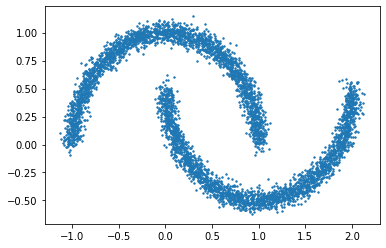

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 2)
        #self.fc4 = nn.Linear(50, 2)
    def __call__(self, z):
        return self.fc3(F.relu(self.fc2(F.relu(self.fc1(z)))))
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
    def __call__(self, x):
        return self.fc3(F.relu(self.fc2(F.relu(self.fc1(x)))))

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.357e+00, generator: 7.511e-01


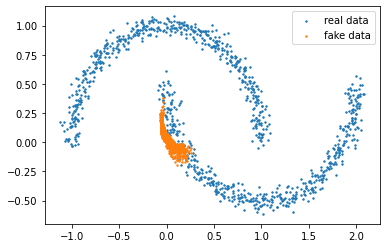

step 1000: discriminator: 9.831e-01, generator: 1.131e+00


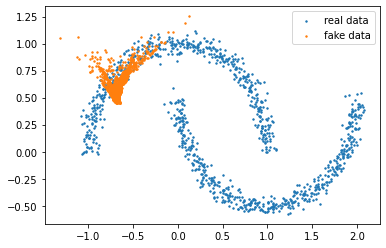

step 2000: discriminator: 1.236e+00, generator: 8.591e-01


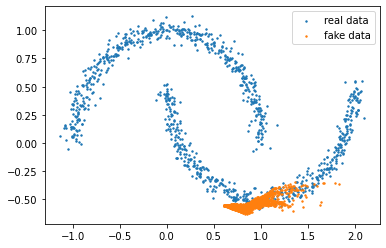

step 3000: discriminator: 1.150e+00, generator: 7.940e-01


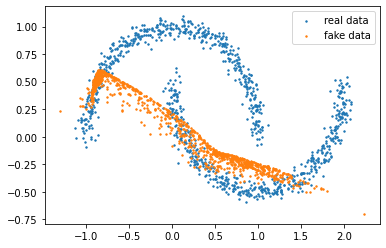

step 4000: discriminator: 1.149e+00, generator: 8.299e-01


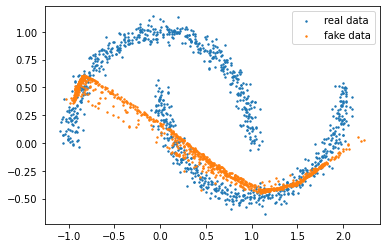

step 5000: discriminator: 1.364e+00, generator: 7.103e-01


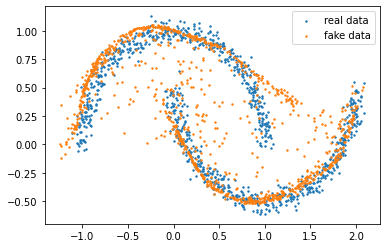

step 6000: discriminator: 1.383e+00, generator: 7.159e-01


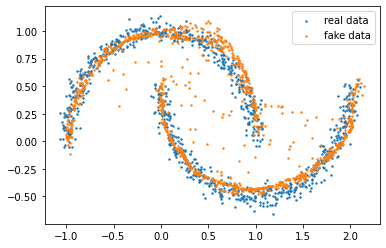

step 7000: discriminator: 1.389e+00, generator: 7.123e-01


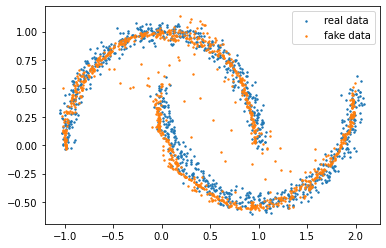

step 8000: discriminator: 1.385e+00, generator: 6.889e-01


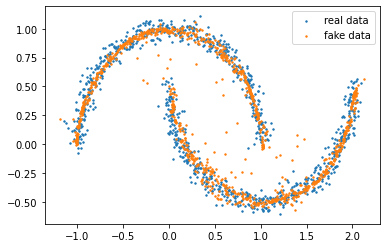

step 9000: discriminator: 1.393e+00, generator: 7.054e-01


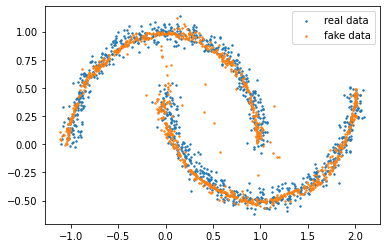

step 10000: discriminator: 1.391e+00, generator: 7.141e-01


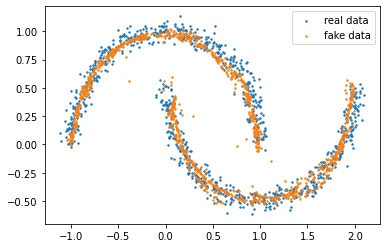

step 11000: discriminator: 1.388e+00, generator: 6.987e-01


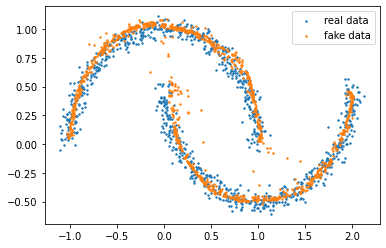

step 12000: discriminator: 1.381e+00, generator: 7.036e-01


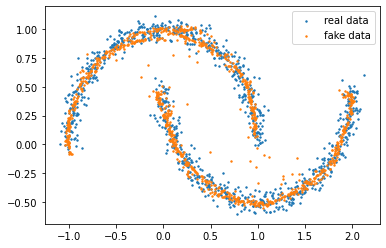

step 13000: discriminator: 1.387e+00, generator: 6.792e-01


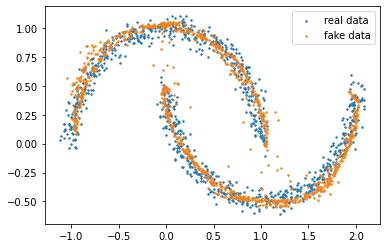

step 14000: discriminator: 1.390e+00, generator: 7.184e-01


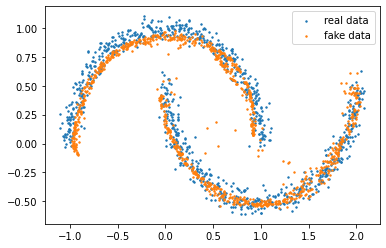

step 15000: discriminator: 1.386e+00, generator: 6.840e-01


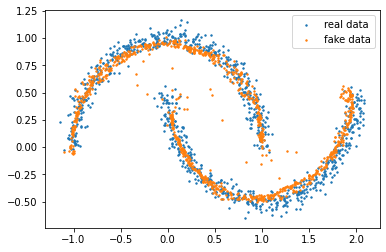

step 16000: discriminator: 1.389e+00, generator: 7.019e-01


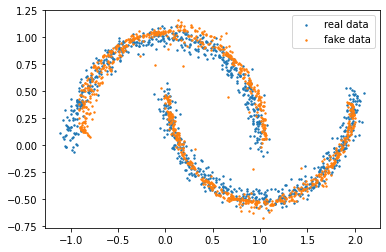

step 17000: discriminator: 1.390e+00, generator: 6.928e-01


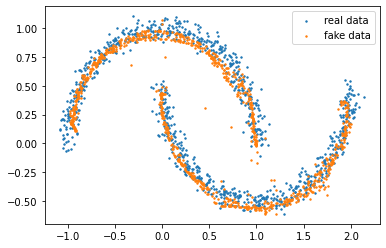

step 18000: discriminator: 1.393e+00, generator: 6.912e-01


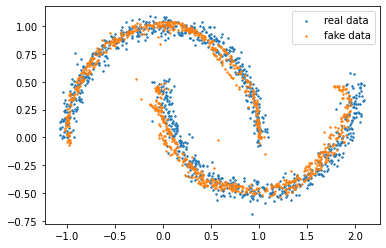

step 19000: discriminator: 1.392e+00, generator: 6.952e-01


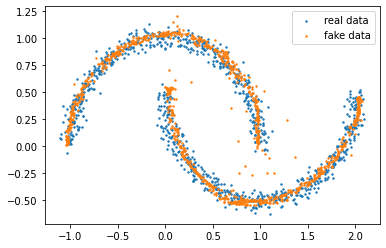

step 20000: discriminator: 1.386e+00, generator: 6.970e-01


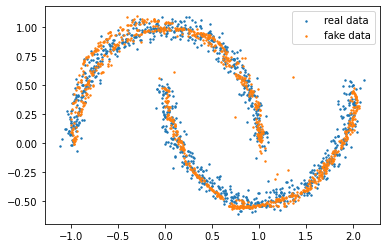

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)

###############################################################################################
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
###############################################################################################        
        real_d = discriminator(real_batch)
        fake_d = discriminator(fake_batch)
        disc_loss = F.softplus(-real_d) + F.softplus(fake_d)
        disc_loss = disc_loss.mean()
###############################################################################################


        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)


###############################################################################################
    # == COMPUTE THE GENERATOR LOSS HERE
###############################################################################################
    fake_d = discriminator(fake_batch)
    gen_loss = F.softplus(-fake_d)
    gen_loss = gen_loss.mean()
###############################################################################################


    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

**A6:** 
> If the discriminator is very good compared to the generator (which is automatic at the beginning, but could happen afterward), the discriminator will just reject every sample from the generator, which would saturate log(1-D(x)) and lead to a very weak gradient. The geneartor will have a hard time improving, because the discriminator is too good, paradoxically.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

**A7:** 
> 

> ***- depth / width of the generator network:***
The generator is obviously unable to generate good sample if it is not complex enough, and a more complex one seems to make the learning unstable, both at the beginning (took longer to separate into the two halves) and at the end, it kept moving its prediction slightly over and over, never stable (probably because the discriminator was not complex enough, making the training at the end unstable).

> ***- depth / width of the discriminator network:***
We don't see the use of an overly complex discriminator compared to the complexity of the generator, in fact the task of the discriminator is much simpler and it should therefore be a simpler model (compared to the generator).

> ***- impact of `TRAIN_RATIO`:***
The impact of train ratio is not very clear from what was tried, but it is reasonable to believe that augmenting it should make the discriminator more capable, which may help guide the generator better. Still, as it was mentionned, a train ratio too high could make the training unstable because of the discriminator being too good and not properly guiding the generator.  



For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

**A8:** 
> $argmin_{\theta} ( D_{KL}(p_D \| p_\theta)) = argmin_{\theta}(\mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right])$
>
> $argmin_{\theta} ( D_{KL}(p_D \| p_\theta))  = argmin_{\theta}(\mathbb{E}_{p_D}\left[ log(p_D) - log(p_\theta)) \right])$
>
>
>
Since $\mathbb{E}_{p_D}\left[ log(p_D) \right]$ is independent from the parameters $\theta$
>
> $argmin_{\theta} ( D_{KL}(p_D \| p_\theta))  = argmin_{\theta}(-\mathbb{E}_{p_D}\left[log(p_\theta)) \right])$
>
So, 
>
> $argmin_{\theta} ( D_{KL}(p_D \| p_\theta))  = argmax_{\theta}\mathbb{E}_{p_D}\left[log(p_\theta)) \right]$ 

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

**A9:** 
> The data generated by a VAE (by first sampling p(z) and then x~p(x|z)) will not represent the real distribution of the dataset.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

**A10:** 
> $D_{KL}(q_\phi(z | x) \| p(z)) = \mathbb{E}_{z \sim p(z)} [ \log q_\phi(z | x) - \log p(z) ] = \mathbb{E}_{z \sim p(z)} [ \log q_\phi(z | x)]  - \mathbb{E}_{z \sim p(z)} [\log p(z) ]$

focusing on the second part, (variance of z_i is 1)

>$\mathbb{E}_{z \sim p(z)} [\log p(z) ] = \mathbb{E}_{z \sim p(z)} [ -\frac{1}{2} (z^Tz) - \frac{1}{2} \log(2\pi)] =  - \frac{1}{2}(\mathbb{E}_{z \sim p(z)} [ (z^Tz)] + \log(2\pi)) =  - \frac{1}{2}(\mathbb{E}_{z \sim p(z)} [ (\Sigma_i z_i^2)] + \log(2\pi)) = - \frac{1}{2}(d + \log(2\pi)) $

for the first part, remember that $\Sigma$ is diagonal, so inversion, multiplication and determinant are easy. In fact it's not hard to prove that the gaussian distrribution is seperable into its individual (single dimension) gaussian distribution, $q_\phi(z | x)= \prod q_{\phi i}(z_i | x) $
>$\mathbb{E}_{z \sim p(z)} [\log q_\phi(z | x) ] = \mathbb{E}_{z \sim p(z)} [ -\frac{1}{2} ((z-\mu)^T\Sigma^{-1} (z-\mu)) - \frac{1}{2} \log(2\pi|\Sigma|)] =  -\frac{1}{2} \mathbb{E}_{z \sim p(z)} [(\Sigma_i \frac{(z-\mu)^2_i}{\sigma_i}) ]- \frac{1}{2} \log(2\pi\prod_i \sigma_{\phi i}^2) $

$= -\frac{1}{2}\left(\Sigma_i  \mathbb{E}_{z \sim p(z)} [\frac{(z_i-\mu_i)^2}{\sigma_i} ] +\log(2\pi\prod_i \sigma_{i}^2) \right) = -\frac{1}{2}\left(\Sigma_i  (\mathbb{E}_{z \sim p(z)} [\frac{z_i^2}{\sigma_i} ] - \mathbb{E}_{z \sim p(z)} [\frac{2z_i\mu_i}{\sigma_i} ] + \mathbb{E}_{z \sim p(z)} [\frac{\mu_i^2}{\sigma_i} ])+\log(2\pi\prod_i \sigma_{i}^2) \right) $
> $=  -\frac{1}{2}\left(\Sigma_i  (\frac{1}{\sigma_i}+\frac{\mu_i^2}{\sigma_i} )+\log(2\pi\prod_i \sigma_{i}^2) \right)  =-\frac{1}{2}\left(\Sigma_i \frac{1 + \mu_i^2}{\sigma_i}+\log(2\pi\prod_i \sigma_i^2) \right) = -\frac{1}{2}\left(\Sigma_i \frac{1 + \mu_i^2}{\sigma_i}+\log(2\pi) + \Sigma_i \log\sigma_{i}^2 \right) $

and so
> $D_{KL}(q_\phi(z | x) \| p(z)) = -\frac{1}{2}\left(\Sigma_i \frac{1 + \mu_i^2}{\sigma_i^2}+\log(2\pi) + \Sigma_i \log\sigma_{i}^2 \right) +  \frac{1}{2}(d + \log(2\pi)) = -\frac{1}{2}\left(\Sigma_i \frac{1 + \mu_i^2}{\sigma_i^2}+ \Sigma_i \log\sigma_{i}^2 - d\right)$

$= \Sigma_i \frac{1 + \mu_i^2}{2\sigma_i^2}+ \Sigma_i \log\sigma_{i} - \frac{d}{2}$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

**A11:**
> $p_\theta(x | z) = \mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$

Applynig a -log to this expression, we get:
>$$-\log p_\theta(x | z) = \displaystyle \frac{N}{2}\log(2\pi)+\frac{1}{2} \log(|Diag(\sigma_\theta(z))|) + \frac{1}{2} (x - \mu_\theta(z))^T Diag(\sigma_\theta(z))^{-1} (x - \mu_\theta(z))$$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.activation = F.relu
        
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc_mu = nn.Linear(50, LATENT_N)
        self.fc_logvar = nn.Linear(50, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        h = self.activation(self.fc1(x))
        h = self.activation(self.fc2(h))
        h = self.activation(self.fc3(h))


        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.activation = F.relu
        
        self.fc1 = nn.Linear(LATENT_N, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc_mu = nn.Linear(100, 2)
        self.fc_logvar = nn.Linear(100, 2)

      
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
             
        h = self.activation(self.fc1(z))
        h = self.activation(self.fc2(h))
        h = self.activation(self.fc3(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar)) 

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 1.013e+01, rec: 1.597e+00


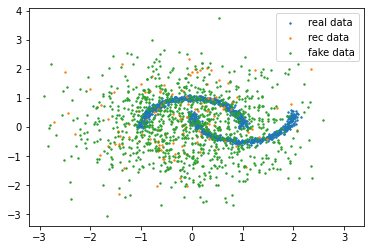

step 1000: KL: 1.926e+01, rec: -1.958e+01


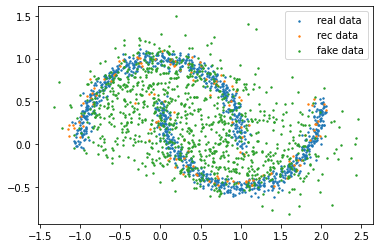

step 2000: KL: 1.990e+01, rec: -2.140e+01


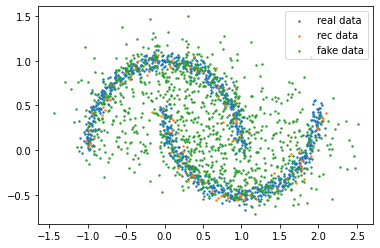

step 3000: KL: 2.008e+01, rec: -2.326e+01


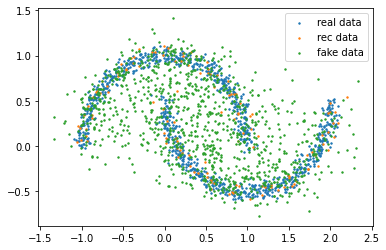

step 4000: KL: 2.045e+01, rec: -2.188e+01


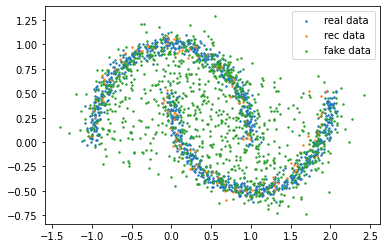

step 5000: KL: 2.077e+01, rec: -2.555e+01


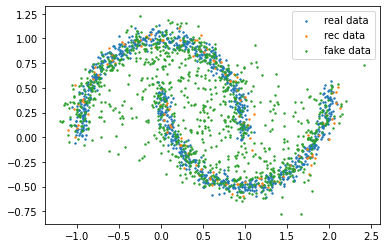

step 6000: KL: 2.093e+01, rec: -2.474e+01


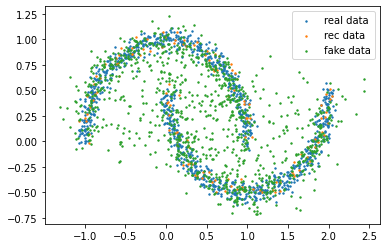

step 7000: KL: 2.123e+01, rec: -2.601e+01


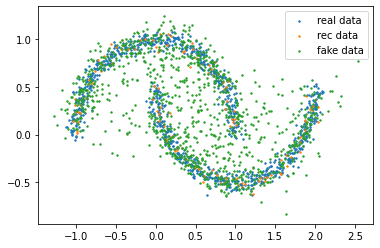

step 8000: KL: 2.121e+01, rec: -2.745e+01


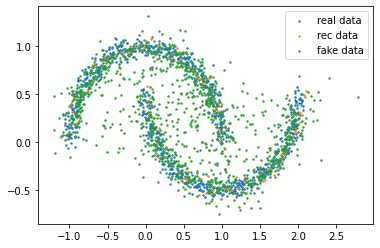

step 9000: KL: 2.168e+01, rec: -2.860e+01


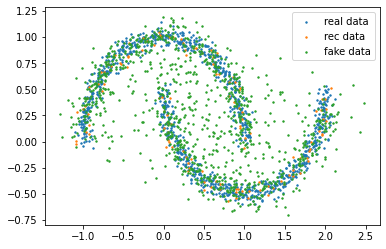

step 10000: KL: 2.191e+01, rec: -2.643e+01


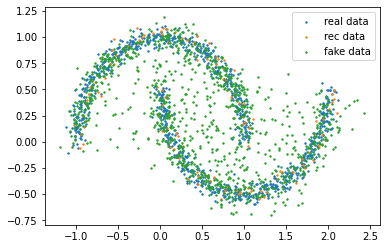

step 11000: KL: 2.206e+01, rec: -2.622e+01


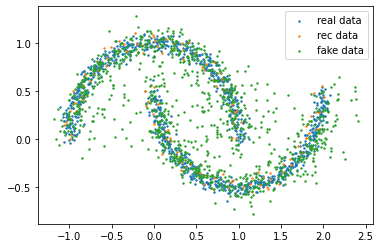

step 12000: KL: 2.197e+01, rec: -2.910e+01


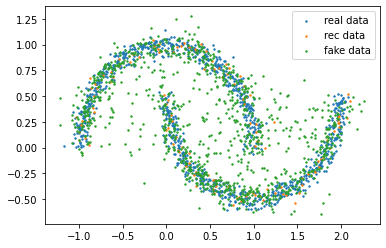

step 13000: KL: 2.197e+01, rec: -2.891e+01


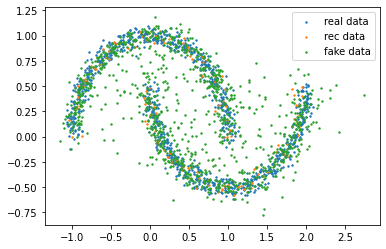

step 14000: KL: 2.213e+01, rec: -2.963e+01


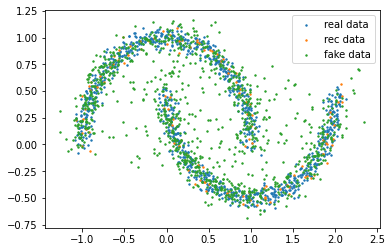

step 15000: KL: 2.232e+01, rec: -3.075e+01


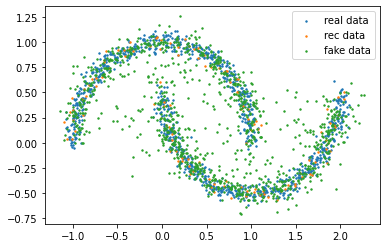

step 16000: KL: 2.243e+01, rec: -2.677e+01


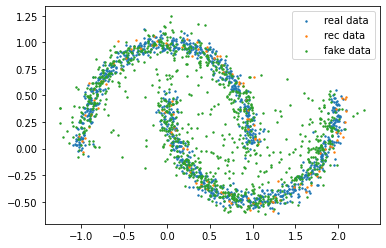

step 17000: KL: 2.266e+01, rec: -3.100e+01


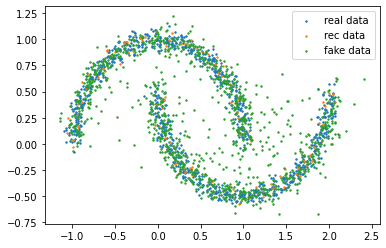

step 18000: KL: 2.261e+01, rec: -3.009e+01


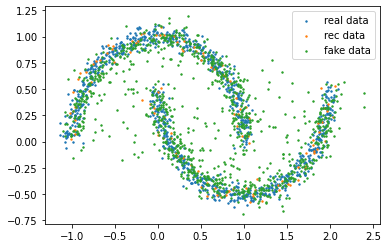

step 19000: KL: 2.274e+01, rec: -3.128e+01


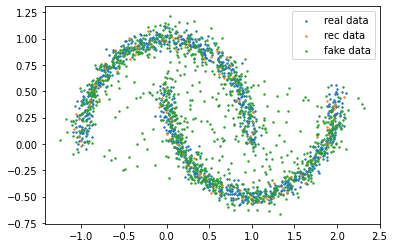

step 20000: KL: 2.278e+01, rec: -2.999e+01


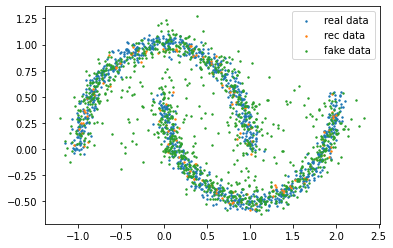

step 21000: KL: 2.276e+01, rec: -3.015e+01


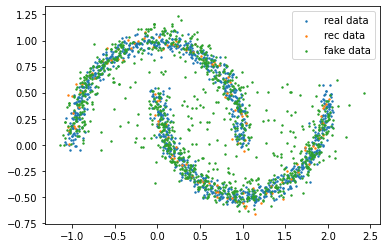

step 22000: KL: 2.285e+01, rec: -2.944e+01


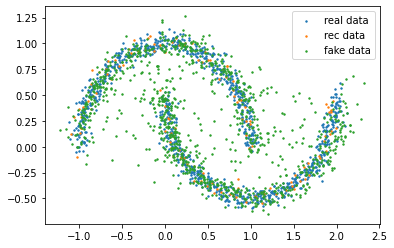

step 23000: KL: 2.298e+01, rec: -3.214e+01


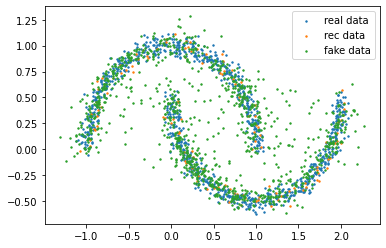

step 24000: KL: 2.292e+01, rec: -3.155e+01


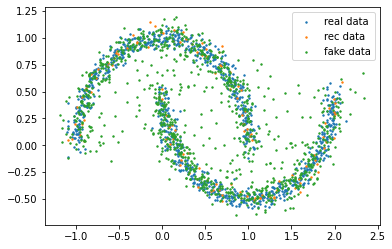

step 25000: KL: 2.283e+01, rec: -3.193e+01


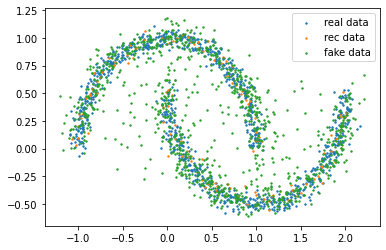

step 26000: KL: 2.296e+01, rec: -2.624e+01


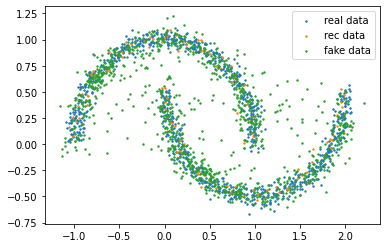

step 27000: KL: 2.304e+01, rec: -3.284e+01


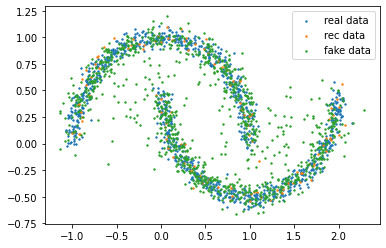

step 28000: KL: 2.326e+01, rec: -3.136e+01


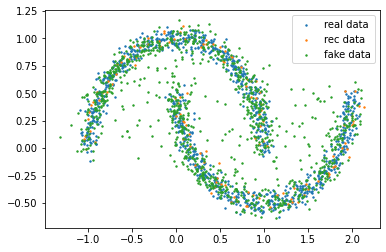

step 29000: KL: 2.334e+01, rec: -2.474e+01


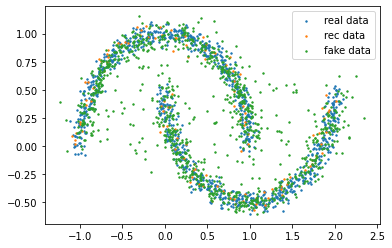

step 30000: KL: 2.322e+01, rec: -2.794e+01


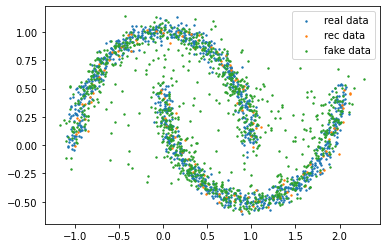

step 31000: KL: 2.331e+01, rec: -3.223e+01


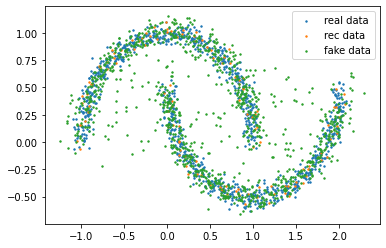

step 32000: KL: 2.341e+01, rec: -2.983e+01


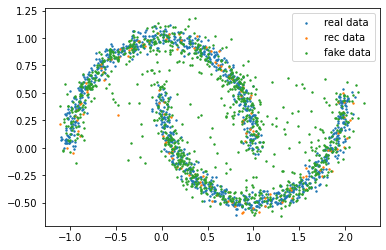

step 33000: KL: 2.355e+01, rec: -3.307e+01


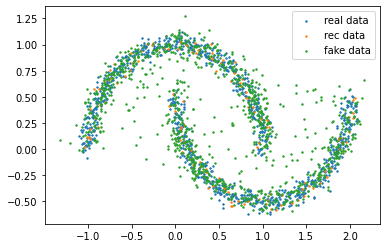

step 34000: KL: 2.352e+01, rec: -2.635e+01


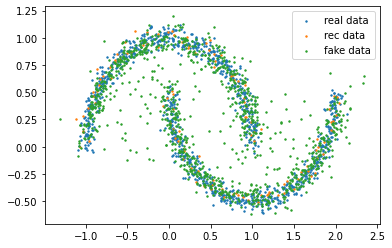

step 35000: KL: 2.339e+01, rec: -3.198e+01


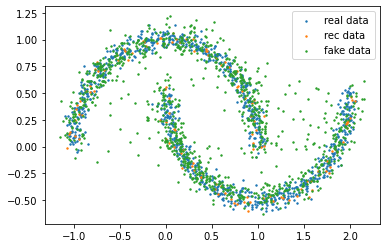

step 36000: KL: 2.355e+01, rec: -3.106e+01


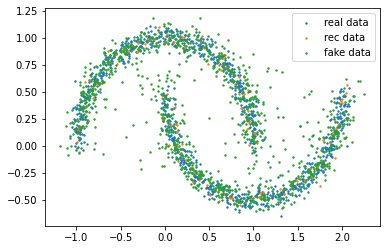

step 37000: KL: 2.372e+01, rec: -3.271e+01


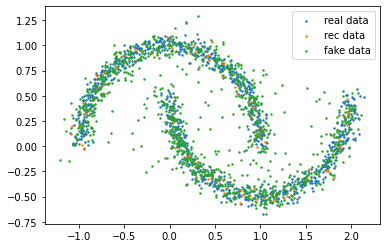

step 38000: KL: 2.349e+01, rec: -3.319e+01


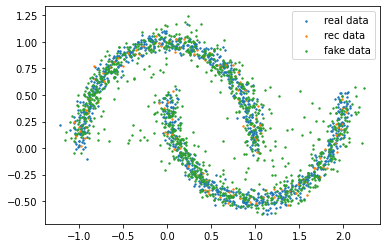

step 39000: KL: 2.372e+01, rec: -3.333e+01


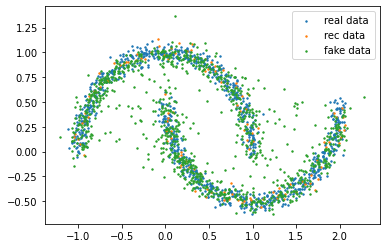

step 40000: KL: 2.371e+01, rec: -3.149e+01


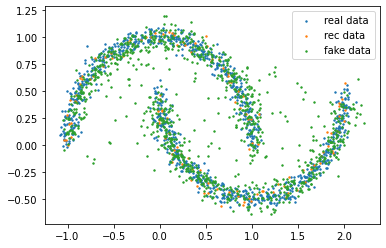

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    #enc_logvar = torch.log(torch.tensor(1e-4))
###############################################################################################
    # COMPUTE THE KL PART OF THE LOSS HERE
###############################################################################################
    loss_logvar_exp = torch.exp(enc_logvar)
    loss_mu = enc_mu**2
    loss_logvar = enc_logvar
    
    loss_kl = torch.sum((loss_logvar_exp + loss_mu - loss_logvar),1)
    loss_kl = loss_kl.mean() 
###############################################################################################


###############################################################################################
    # SAMPLE z FROM q(z|x) HERE
###############################################################################################
    z = torch.normal(torch.zeros(BATCHLEN, LATENT_N), 1)
    z *= torch.exp(0.5*enc_logvar)
    z += enc_mu  
###############################################################################################


    dec_mu, dec_logvar = decoder(z)


###############################################################################################
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
###############################################################################################
    loss_logvar_exp_dec = torch.exp(-dec_logvar)
    loss_mu_dec = (x-dec_mu)**2
    loss_logvar_dec = 2*dec_logvar

    loss_rec = torch.sum(((loss_logvar_exp_dec * loss_mu_dec) + loss_logvar_dec),1)
    loss_rec = loss_rec.mean()
###############################################################################################
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

**A12:**
> it seemed to focus its output onto one specific region of the dataset, as if their was a mode collapse.

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

**A13:**
> In general, beyond the dificulty of training when there are too many parameters and the lack of generalization when the decoder is too weak (it is not powerful enough to represent the dataset).
>
> a sufficient decoder but a weak encoder makes hard learning about the points that are in between the two moons (the vae struggle to properly separate the two dataset)
>
>So, A good VAE requires both a good encoder and a good decoder.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

**A14:**
>$\log(p_G(x))=\log(p_\mathcal{N}(z=f(x)))+\log (| \det J_f(x)|)$,
>
>we know that $p_G(x)/| \det J_f(x)| = p_\mathcal{N}(z=f(x))$ from the fact that f(x) is deforming the space by precisely $| \det J_f(x)|$, the identity then follows by a multiply and a log on both side.

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

**A15:**
> $KL(p_D \| p_G) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_G}) \right] = \mathbb{E}_{p_D}\left[ log(p_D)\right] - \mathbb{E}_{p_D}\left[ log(p_G) \right] =  - \mathbb{E}_{p_D}\left[\log(p_\mathcal{N}(z=f(x))) - \log (|\det J_f(x)|)\right]$

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

**A16:**
>we still have:            
> $x_{1:d}=y_{1:d}$

and for the rest, it follows quickly by applying the equality above in s an t, and inverting t then s (t is just a negation, and for s we take the exponentail of the neagtive of s):
> $y_{d+1:D} - t(y_{1:d})=x_{d+1:D}\odot \exp(s(y_{1:d}))$

then
> $(y_{d+1:D} - t(y_{1:d}))\odot \exp(-s(y_{1:d}))=x_{d+1:D}$

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

**A17:**
>
If we remember the definition of the jacobian, we can get the triangular matrix


> $J_f(x) = [\frac{\partial y_{d+1:D}}{\partial x_{d+1:D}}, \frac{\partial y_{d+1:D}}{\partial x_{1:d}}; 0, \frac{\partial y_{1:d}}{\partial x_{1:d}}] = [\frac{\partial y_{d+1:D}}{\partial x_{d+1:D}}, \frac{\partial y_{d+1:D}}{\partial x_{1:d}}; 0, I]$

And we know that the determinant of this matrix is the product of the diagonal, and therefore we have 
> $det J_f(x) = det \frac{\partial y_{d+1:D}}{\partial x_{d+1:D}} = det \frac{\partial x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})}{\partial x_{d+1:D}}$

which is itself diagonal, and we get 

> $det J_f(x) = \prod_j\exp(s(x_{1:d})_j) =\exp( \sum_js(x_{1:d})_j)$


**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
############ define here variables to use in f and s #############
        self.fc1s = nn.Linear(input_size, hidden_size)
        self.fc2s = nn.Linear(hidden_size , hidden_size)
        self.fc3s = nn.Linear(hidden_size , output_size)
        self.fc1t = nn.Linear(input_size, hidden_size)
        self.fc2t = nn.Linear(hidden_size , hidden_size)
        self.fc3t = nn.Linear(hidden_size , output_size)
###################################################################
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        x_m = F.leaky_relu(self.fc1s(x_m))
        x_m = F.leaky_relu(self.fc2s(x_m))
        x_m = F.tanh(self.fc3s(x_m))
        return x_m
        
    def tfun(self, x_m):
        x_m = F.leaky_relu(self.fc1t(x_m))
        x_m = F.leaky_relu(self.fc2t(x_m))
        x_m = self.fc3t(x_m)
        return x_m
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        s_out = self.sfun(y_m) # multiplicative block
        t_out = self.tfun(y_m) # additive block
        x = y_m + (1-self.mask)*((y-t_out) * torch.exp(-s_out))
        return x


In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch



def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)






def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)


In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.018661
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.041454
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.050098
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.052321
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.053223
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.054834
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.054911
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.055874
====> Epoch: 1 Average train loss: -0.0486


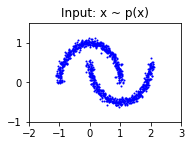

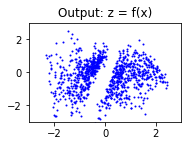

====> Test loss: -0.0574


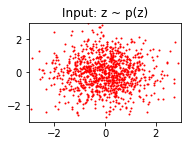

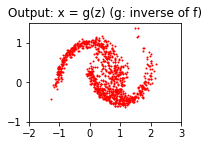

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.056140
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.055999
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.056518
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.057649
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.057610
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.058342
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.058401
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.057245
====> Epoch: 2 Average train loss: -0.0570


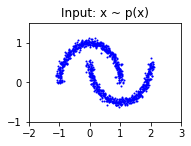

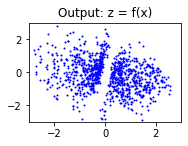

====> Test loss: -0.0586


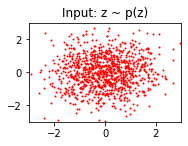

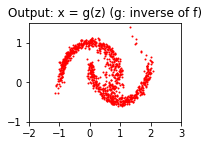

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.057531
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.058524
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.056400
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.057650
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.057888
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.059477
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.058719
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.058956
====> Epoch: 3 Average train loss: -0.0579


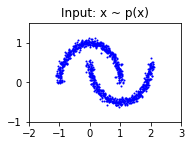

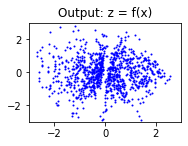

====> Test loss: -0.0595


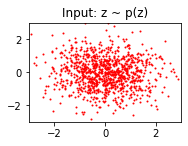

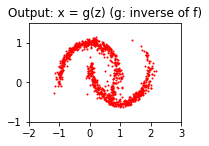

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.058751
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.057753
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.058136
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.057846
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.059104
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.058720
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.059110
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.058637
====> Epoch: 4 Average train loss: -0.0586


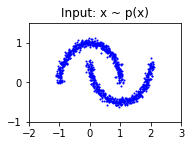

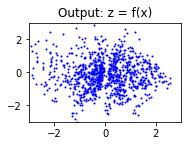

====> Test loss: -0.0595


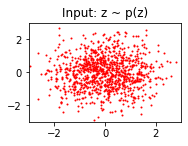

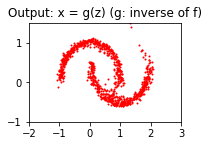

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.059039
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.057985
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.057861
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.059187
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.059548
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.057628
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.059390
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.059183
====> Epoch: 5 Average train loss: -0.0587


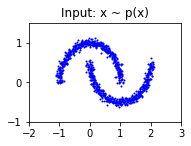

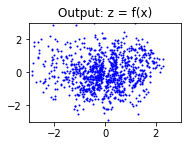

====> Test loss: -0.0598


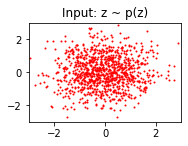

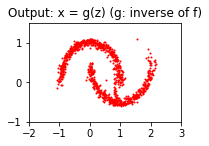

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.058840
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.059406
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.057905
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.058482
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.059655
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.058592
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.059257
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.059026
====> Epoch: 6 Average train loss: -0.0590


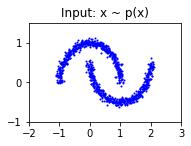

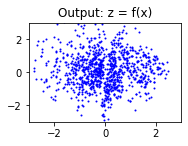

====> Test loss: -0.0597


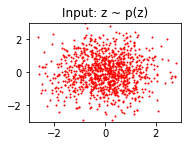

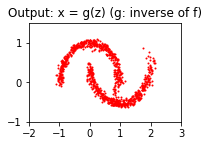

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.059152
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.058849
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.058528
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.058535
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.058826
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.058436
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.059075
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.058723
====> Epoch: 7 Average train loss: -0.0591


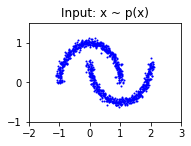

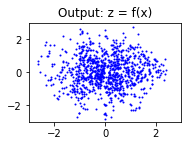

====> Test loss: -0.0599


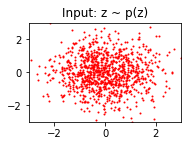

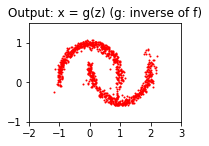

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.059479
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.059504
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.059231
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.059581
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.058827
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.059036
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.058653
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.059607
====> Epoch: 8 Average train loss: -0.0592


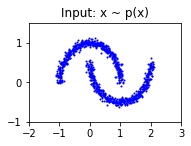

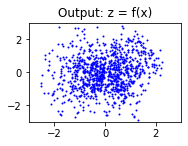

====> Test loss: -0.0601


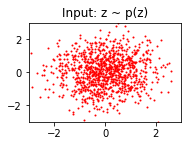

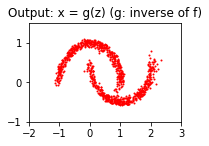

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.059249
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.058445
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.059600
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.059999
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.059470
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.058185
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.058800
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.058935
====> Epoch: 9 Average train loss: -0.0592


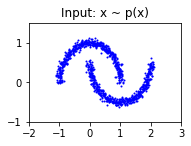

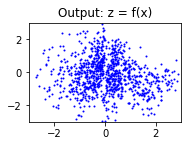

====> Test loss: -0.0596


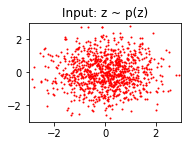

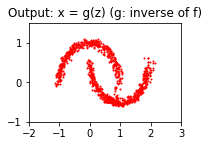

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.059053
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.059236
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.059269
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.058863
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.059979
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.058819
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.059853
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.058536
====> Epoch: 10 Average train loss: -0.0593


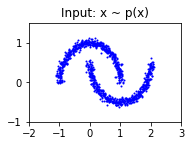

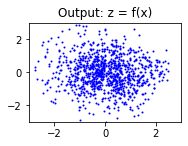

====> Test loss: -0.0605


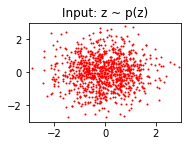

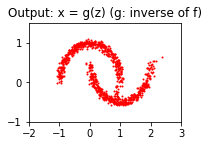

'522.29s'

<Figure size 432x288 with 0 Axes>

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

**A19:**
> As we can see in the training graphs, it is hard for NF to divide the normal cluster into multiple ones. The other methods can achieve this more easily by not enforcing invertibility. 
>
>With NF, you need to have a relatively smooth transtion between the two clusters, and this make the middle of the gaussian be mapped right in between the different cluster. 
>
>It can be seen as an extension from their assumption of invertibility from a distibution with one mode.

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

**A20:**
> Gans are clearly the hardest to train, but they are clearly the most expressive (as can be seen in many works). They learn a straightforward loss, even though it is a model without any assurance to converge. In fact when training over and over, we can see that the beginning is never the same, it took a variable amount of time to find the two moons. The end too, sometimes it managed to stabilize, sometimes not, and the final result was sometimes quite approximative. 
>
>VAE are the easiest to train in a way, although they cannot represent as many things as GANs, and they have a better explanatory power with their use of latent space. 
>
>Finally, normalizing flows have the advantage of having a clear, invertible function (which could be useful in some settings), but they also have difficulties learning even standard distributions. They also seem slow to learn, in part because the invertibility requires that each of the blocs (in this architecture) starts and ends with the same dimensions.